In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # 대화형 모드

In [18]:
# 데이터셋 준비

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = '../data/c02/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
print(dataset_sizes['train'], dataset_sizes['val'])

cuda:0
244 153


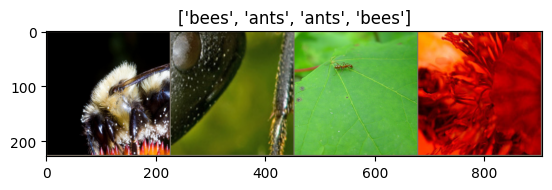

In [10]:
# 일부 이미지 시각화

def imshow(inp, title=None):
    # tensor를 입력받아 이미지로 출력
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(dataloaders['train'])) # batch_size = 4 이므로 4개씩 보여짐

out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [16]:
# 모델 학습하기

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        #각 epoch은 학습과 검증을 진행
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                
                # 순전파
                # 학습 시에만 연산 시록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습시에만 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                #통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # 모델을 깊은복사함
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

In [12]:
# 모델 예측값 시각화

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
                
        model.train(mode=was_training)

In [13]:
# finetuning

model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features

# 각 출력 샘플의 크기는 2
# 또는 nn.Linear(num_ftrs, len(class_names))로 일반화 할 수 있다
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer=optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\USER/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 93.2MB/s]


In [17]:
# 학습 및 평가하기
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6011 Acc: 0.7008
val Loss: 0.2726 Acc: 0.8824

Epoch 1/24
----------
train Loss: 0.5442 Acc: 0.7500
val Loss: 0.2798 Acc: 0.9150

Epoch 2/24
----------
train Loss: 0.4264 Acc: 0.7910
val Loss: 0.3468 Acc: 0.8954

Epoch 3/24
----------
train Loss: 0.5244 Acc: 0.7951
val Loss: 0.2742 Acc: 0.8954

Epoch 4/24
----------
train Loss: 0.5307 Acc: 0.7910
val Loss: 0.8141 Acc: 0.7516

Epoch 5/24
----------
train Loss: 0.4539 Acc: 0.8279
val Loss: 0.2259 Acc: 0.9150

Epoch 6/24
----------
train Loss: 0.4305 Acc: 0.8279
val Loss: 0.2645 Acc: 0.8824

Epoch 7/24
----------
train Loss: 0.3733 Acc: 0.8279
val Loss: 0.2499 Acc: 0.9020

Epoch 8/24
----------
train Loss: 0.2548 Acc: 0.8934
val Loss: 0.2467 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.3790 Acc: 0.8320
val Loss: 0.2460 Acc: 0.9085

Epoch 10/24
----------
train Loss: 0.3068 Acc: 0.8689
val Loss: 0.3308 Acc: 0.8627

Epoch 11/24
----------
train Loss: 0.3426 Acc: 0.8484
val Loss: 0.2245 Acc: 0.9085

Ep

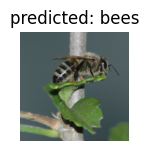

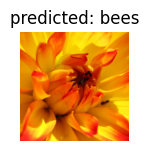

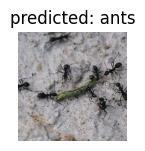

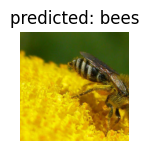

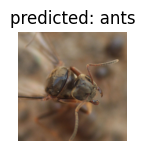

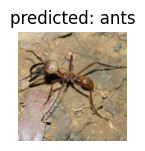

In [19]:
visualize_model(model_ft)